# ACTS-MU10-PT1000-T50

In [ ]:
!nvidia-smi

In [1]:
import os
import random
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.


### Load in the data.

In [ ]:
filepath  = "data/sets/ACTS/ACTS-MU10-PT1000-COMPLETE.gz"
frame = pd.read_csv(filepath)
frame.head(5)

In [ ]:
%%time
max_tracks = 50
filt   = lambda a: len(a["cluster_id"].unique()) <= max_tracks
events = frame.groupby("event_id").filter(filt)


In [ ]:
a = events.groupby("event_id")
#print(len(events))
#print(len(events["event_id"].unique()))
print(max([len(e["cluster_id"].unique()) for (_, e) in a]))

In [ ]:
%%time
savepath = "data/sets/ACTS/ACTS-MU10-PT1000-T50-PREPARED.gz"
prepared = ext.prepare_frame(events, n_tracks=50, n_rows=200)

In [3]:
%%time
modelpath = "data/models/ACTS-MU10-PT1000-T50.h5"
filepath  = "data/sets/ACTS-MU10-PT1000-T50-PREPARED.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del events

Train is list of 52325 events.
Test is list of 13082 events.
Train takes up 418664 bytes.
Test takes up 104720 bytes.
Wall time: 51.6 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [5]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 430 events with 1 tracks.
There are 470 events with 2 tracks.
There are 607 events with 3 tracks.
There are 638 events with 4 tracks.
There are 676 events with 5 tracks.
There are 795 events with 6 tracks.
There are 774 events with 7 tracks.
There are 850 events with 8 tracks.
There are 848 events with 9 tracks.
There are 927 events with 10 tracks.
There are 899 events with 11 tracks.
There are 934 events with 12 tracks.
There are 970 events with 13 tracks.
There are 1050 events with 14 tracks.
There are 1076 events with 15 tracks.
There are 1132 events with 16 tracks.
There are 1077 events with 17 tracks.
There are 1112 events with 18 tracks.
There are 1170 events with 19 tracks.
There are 1167 events with 20 tracks.
There are 1135 events with 21 tracks.
There are 1231 events with 22 tracks.
There are 1212 events with 23 tracks.
There are 1206 events with 24 tracks.
There are 1258 events with 25 tracks.
There are 1287 events with 26 tracks.
There are 1226 events with 27 trac

In [6]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 92 events with 1 tracks.
There are 132 events with 2 tracks.
There are 142 events with 3 tracks.
There are 137 events with 4 tracks.
There are 192 events with 5 tracks.
There are 173 events with 6 tracks.
There are 186 events with 7 tracks.
There are 226 events with 8 tracks.
There are 243 events with 9 tracks.
There are 209 events with 10 tracks.
There are 244 events with 11 tracks.
There are 247 events with 12 tracks.
There are 248 events with 13 tracks.
There are 261 events with 14 tracks.
There are 279 events with 15 tracks.
There are 254 events with 16 tracks.
There are 267 events with 17 tracks.
There are 310 events with 18 tracks.
There are 284 events with 19 tracks.
There are 293 events with 20 tracks.
There are 309 events with 21 tracks.
There are 305 events with 22 tracks.
There are 302 events with 23 tracks.
There are 332 events with 24 tracks.
There are 321 events with 25 tracks.
There are 330 events with 26 tracks.
There are 287 events with 27 tracks.
There are 3

### Show an example of the data.

Train 24295
Number of Hits: 64
Number of Tracks: 23


<IPython.core.display.Javascript object>


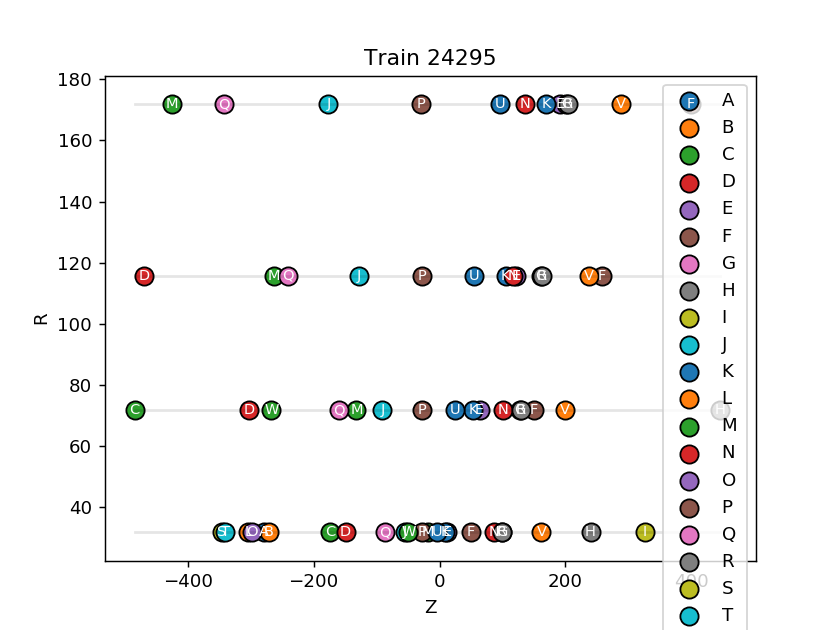

<IPython.core.display.Javascript object>


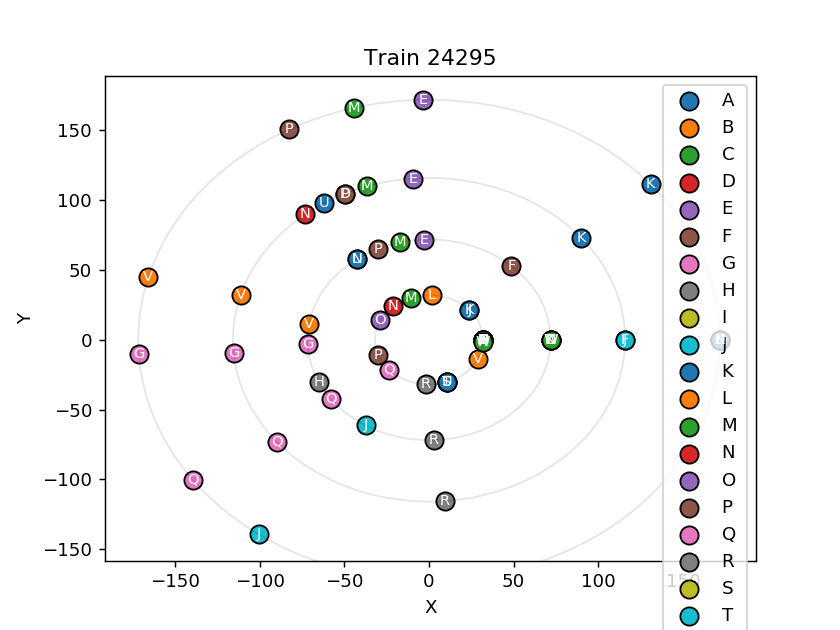

In [7]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [8]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,0.000000,31.959895,-279.22800,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000000,31.959895,-271.60600,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,31.959895,-174.32500,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.000000,31.959895,-149.20900,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.000000,31.959895,12.41560,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.000000,31.959895,50.07500,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,0.000000,31.959895,99.03750,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.000000,31.959895,239.93700,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.000000,31.959895,326.78400,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,0.000000,71.842967,-484.27800,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [9]:
input_shape  = (200, 3)
n_categories = 50 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [11]:
model = keras.models.load_model(modelpath)

TypeError: ('Keyword argument not understood:', 'return_state')

In [13]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 200, 256)          399360    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200, 256)          787968    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 256)          787968    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 200, 52)           13364     
Total para

### Fit the model.

In [ ]:
%%time
epochs     = 128
batch_size = 50
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/128
1046/1046 [==============================] - 1116s - loss: 1.2599 - acc: 0.6502 - val_loss: 0.9899 - val_acc: 0.7079
Epoch 2/128
1046/1046 [==============================] - 1096s - loss: 1.0032 - acc: 0.7098 - val_loss: 0.8602 - val_acc: 0.7622
Epoch 3/128
1046/1046 [==============================] - 1085s - loss: 0.9124 - acc: 0.7448 - val_loss: 0.7989 - val_acc: 0.7803
Epoch 4/128
1046/1046 [==============================] - 1086s - loss: 0.8695 - acc: 0.7611 - val_loss: 0.7792 - val_acc: 0.7854
Epoch 5/128
1046/1046 [==============================] - 1104s - loss: 0.8468 - acc: 0.7681 - val_loss: 0.7653 - val_acc: 0.7889
Epoch 6/128
1046/1046 [==============================] - 1078s - loss: 0.8323 - acc: 0.7723 - val_loss: 0.7545 - val_acc: 0.7926
Epoch 7/128
 877/1046 [========================>.....] - ETA: 156s - loss: 0.8221 - acc: 0.7752

### Display information about the model after fitting it.

In [ ]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

### Display how one of the model's predictions looks.

In [ ]:
%matplotlib notebook

In [ ]:
n  = np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
#_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [ ]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

In [ ]:
importlib.reload(metrics)

In [ ]:
print(min([event["momentum"].min() for event in test]))
print(max([event["momentum"].max() for event in test]))

In [ ]:
%%time
momentums = [1 + 1/8, 1 + 1/4, 1 + 1/2, 2, 4, 8, 16, 32, 64, 128]
momentums, momentum_acc = metrics.accuracy_vs_momentum(test, guesses, order, momentums)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
for acc in momentum_acc:
    print(len([b for b in acc if b == 1]) / len(acc))

In [ ]:
for i, momentum in enumerate(momentums):
    accuracy = momentum_acc[i]
    if accuracy:
        plt.hist(accuracy, bins=5, range=(0, 1), align="mid", edgecolor='black', linewidth=2, color='green')
        plt.title("Momentum: {0} - {1}".format(momentums[i-1] if i > 0 else 1, momentum))
        plt.xlabel("Probability that hit within track was correctly classified")
        plt.ylabel("Tracks with this momentum")
        plt.grid(True)
        plt.show()

In [ ]:
%matplotlib notebook
visuals.boxplot(
    data   = momentum_acc.tolist(),
    fliers = True,
    ylabel = "Probability",
    xlabel = "Momentum",
    title  = "Prob[Hit within track belongs to track] vs Momentum",
    xticks = momentums
)

In [ ]:
%%time
bend_amounts = [i for i in range(0, 500, 25)]
bends, acc = metrics.accuracy_vs_bend(test, guesses, order, bend_amounts)
visuals.boxplot(
    data   = acc.tolist(),
    fliers = False,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = bends
)

In [ ]:
print(len(test))

In [ ]:
%%time
boxes = [[] for _ in range(30)]
for i, event in enumerate(test):
    crossings    = metrics.number_of_crossings(event)
    hits_correct = metrics.percent_of_hits_assigned_correctly(event, guesses[i], order) 
    boxes[crossings].append(hits_correct)
visuals.boxplot(
    data   = boxes,
    fliers =False,
    ylabel = "Probability",
    xlabel = "Crosses",
    title  = "Prob[Hit belongs to right track in event] vs Number of Crossings",
    xticks = [i for i in range(len(boxes))]
)